<a href="https://colab.research.google.com/github/settilea/Leandro_Setti_Proyecto_final_DataScience2/blob/main/LeandroSetti_Proyecto_Data_Science2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚖 NYC Taxi Trip Duration Analysis & Prediction
## 📋 Descripción del Proyecto
Este proyecto de Data Science tiene como objetivo predecir la duración total de viajes en taxi en la ciudad de Nueva York. Utilizando un enfoque de **Machine Learning** y **Análisis Geoespacial**, el modelo no solo considera variables temporales (hora/día), sino que enriquece los datos con información climática y características espaciales complejas (barrios y rutas teóricas).

El proyecto simula un escenario real de logística urbana donde la estimación precisa del tiempo de llegada (ETA) es crítica para la eficiencia operativa.

## 🎯 Objetivos
* Realizar un Análisis Exploratorio de Datos (EDA) profundo sobre el dataset de Taxis de NYC.
* Enriquecer el dataset original con datos externos: **Clima** y **Polígonos de Barrios (GeoJSON)**.
* Implementar ingeniería de características geoespaciales (Spatial Joins) para determinar zonas de origen y destino.
* Utilizar la **API de OSRM** para calcular rutas óptimas teóricas y comparar distancias de manejo vs. distancias euclidianas.
* Entrenar modelos de regresión (Linear, Random Forest, XGBoost) para predecir la duración del viaje.

## Instalación e importación de librerías necesarias para el proyecto

In [1]:
!pip install geopandas shapely polyline


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from google.colab import userdata
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual para ver todas las columnas
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore') # Para que no molesten los avisos de versiones

print("¡Librerías cargadas correctamente!")

¡Librerías cargadas correctamente!


## Carga del dataset
Cargamos el dataset directamente desde Kaggle, mediante la API

In [3]:
try:
    os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
    print("✅ Credenciales cargadas correctamente desde Secrets.")
except Exception as e:
    print("❌ Error: No se encontraron los secretos. Revisa el ícono de la Llave en la barra lateral.")

# 2. Descargar el dataset (Igual que antes, pero ahora "mágicamente" tiene permiso)
!kaggle datasets download -d yasserh/nyc-taxi-trip-duration

# 3. Descomprimir
!unzip -q -o nyc-taxi-trip-duration.zip  # -o para sobrescribir si ya existe

# 4. Verificar
import pandas as pd
print("\nArchivos listos:")
print(os.listdir())

✅ Credenciales cargadas correctamente desde Secrets.
Dataset URL: https://www.kaggle.com/datasets/yasserh/nyc-taxi-trip-duration
License(s): CC0-1.0
  0% 0.00/63.9M [00:00<?, ?B/s]
100% 63.9M/63.9M [00:00<00:00, 709MB/s]

Archivos listos:
['.config', 'NYC.csv', 'nyc-taxi-trip-duration.zip', 'sample_data']


## Análisis exploratorio del dataset
una vez extraidos los archivos de Kaggle vamos a realiza los primeros análisis para poder entender la información que tenemos

In [4]:
# 1. Cargar el archivo
print("Cargando dataset...")
df = pd.read_csv('NYC.csv')

# 2. Verificación rápida
print(f"¡Carga completa! El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
display(df.head())

Cargando dataset...
¡Carga completa! El dataset tiene 1458644 filas y 11 columnas.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
# vemos los formatos de todos los campos
df.dtypes

In [5]:
# Convertir columnas de texto a fecha (Datetime), vital para poder sacar "hora del día", "día de la semana", etc.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

display(df.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
# A. Ver tipos de datos y nulos
print("--- INFO GENERAL ---")
df.info()

# B. Estadísticas descriptivas
print("\n--- ESTADÍSTICAS ---")
# Usamos float_format para no ver notación científica (ej: 1.2e+05)
display(df.describe().apply(lambda s: s.apply('{0:.2f}'.format)))

--- INFO GENERAL ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB

--- ESTADÍSTICAS ---


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,.2f,.2f,1.66,-73.97,40.75,-73.97,40.75,959.49
min,1.00,.2f,.2f,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,.2f,.2f,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,.2f,.2f,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,.2f,.2f,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,.2f,.2f,9.00,-61.34,51.88,-61.34,43.92,3526282.00
std,0.50,nan,nan,1.31,0.07,0.03,0.07,0.04,5237.43


## Descripción de los atributos del dataset
###¿Qué representa cada variable del dataset?

- **id**: Un identificador único para cada viaje.
- **vendor_id**: Un código que indica el proveedor asociado con el registro del viaje.
- **pickup_datetime**: Fecha y hora en la que se activó el taxímetro.
- **dropoff_datetime**: Fecha y hora en la que se desactivó el taxímetro.
- **passenger_count**: El número de pasajeros en el vehículo (valor ingresado por el conductor).
- **pickup_longitude**: La longitud donde se activó el taxímetro.
- **pickup_latitude**: La latitud donde se activó el taxímetro.
- **dropoff_longitude**: La longitud donde se desactivó el taxímetro.
- **dropoff_latitude**: La latitud donde se desactivó el taxímetro.
- **store_and_fwd_flag**: Bandera que indica si el registro del viaje se mantuvo en la memoria del vehículo antes de enviarse al proveedor por falta de conexión (`Y` = sí, almacenado y enviado; `N` = no).
- **trip_duration**: Duración del viaje en segundos

## Limpieza de Datos
### Duración del vieje
Usaremos primero el IQR y validamos si es un criterio razonable

In [8]:
# 1. Cálculo de los cuartiles estándar
Q1 = df['trip_duration'].quantile(0.25)
Q3 = df['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# 2. Se calcula el "Límite Superior" según la regla del IQR
# La regla es: Todo lo que sea mayor a Q3 + 1.5 veces el IQR es un outlier
limite_iqr = Q3 + 1.5 * IQR

# 3. Se analiza el impacto
# Se filtra "mentalmente" para ver qué perderíamos
viajes_eliminados = df[df['trip_duration'] > limite_iqr]
cantidad_eliminada = len(viajes_eliminados)
porcentaje_eliminado = (cantidad_eliminada / len(df)) * 100

print(f"--- ANÁLISIS DEL MÉTODO IQR ---")
print(f"Q1 (25%): {Q1/60:.1f} min")
print(f"Q3 (75%): {Q3/60:.1f} min")
print(f"IQR: {IQR/60:.1f} min")
print(f"--------------------------------")
print(f"Límite de Corte Sugerido (Upper Fence): {limite_iqr:.0f} segundos")
print(f"ESTO EQUIVALE A: {limite_iqr/60:.2f} MINUTOS")
print(f"--------------------------------")
print(f"Si se usa IQR, se eliminarían {cantidad_eliminada} viajes.")
print(f"Se estarían borrando el {porcentaje_eliminado:.2f}% de la base de datos.")

# 4. Ejemplos de lo que el IQR considera "outlier"
print("\n--- EJEMPLOS DE VIAJES QUE EL IQR BORRARÍA ---")
print(viajes_eliminados[['trip_duration']].head(5)/60)

--- ANÁLISIS DEL MÉTODO IQR ---
Q1 (25%): 6.6 min
Q3 (75%): 17.9 min
IQR: 11.3 min
--------------------------------
Límite de Corte Sugerido (Upper Fence): 2092 segundos
ESTO EQUIVALE A: 34.87 MINUTOS
--------------------------------
Si se usa IQR, se eliminarían 74220 viajes.
Se estarían borrando el 5.09% de la base de datos.

--- EJEMPLOS DE VIAJES QUE EL IQR BORRARÍA ---
    trip_duration
2       35.400000
16      38.600000
24      41.416667
29      38.850000
33      37.816667


El límite superior e inferior no son valores razonables para utilizarse como parámetro de registros "Outliers".
Usaremos un método de lógica del negocio.
  1 - **Límite Inferior (Lógica)**: Un viaje de taxi de menos de 60 segundos es, casi seguro, un error, un viaje cancelado o un cambio de vehículo. No aporta valor predictivo.

  2- **Límite Superior (Percentiles)**: En lugar de adivinar si el corte es a las 2 o 3 horas, usamos el Percentil 99. Esto significa: "Quedémonos con el 99% de los viajes y eliminemos el 1% más extremo" (que suelen ser los errores de GPS que duran días).

El 1% de los viajes dura menos de: 87.00 segundos
El 99% de los viajes dura menos de: 3440.00 segundos (57.33 minutos)

--- APLICANDO FILTROS ---
Mantendremos viajes entre 60 seg y 3440.0 seg


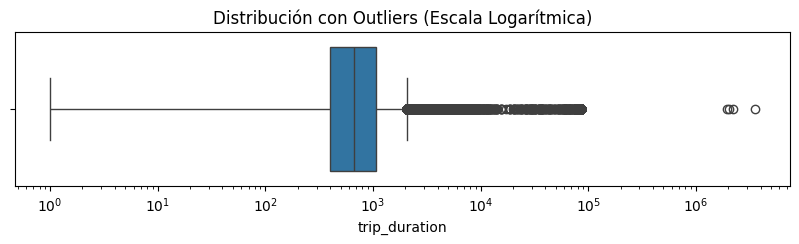


Filas originales: 1458644
Filas después de limpieza: 1435474
Se eliminaron 23170 filas (1.59%)


In [9]:
# 1. Calcular los límites estadísticos
# Percentil 1 (para ver los muy cortos) y 99 (para los muy largos)
p1 = np.percentile(df['trip_duration'], 1)
p99 = np.percentile(df['trip_duration'], 99)

print(f"El 1% de los viajes dura menos de: {p1:.2f} segundos")
print(f"El 99% de los viajes dura menos de: {p99:.2f} segundos ({p99/60:.2f} minutos)")

# 2. Definir nuestros límites de corte (Thresholds)
# Mínimo: 60 segundos (Lógica de negocio: menos de 1 min no es un viaje útil)
# Máximo: Usamos el p99 o un tope fijo de 24 horas si el p99 fuera absurdo.
# En este dataset, el p99 suele rondar los 3000-4000 segundos, que es razonable.
MIN_DURATION = 60
MAX_DURATION = p99 # O puedes poner manualmente 10800 (3 horas) si prefieres ser conservador

print(f"\n--- APLICANDO FILTROS ---")
print(f"Mantendremos viajes entre {MIN_DURATION} seg y {MAX_DURATION} seg")

# 3. Visualizar ANTES del corte (Boxplot) para que veas la locura de los outliers
plt.figure(figsize=(10, 2))
plt.title("Distribución con Outliers (Escala Logarítmica)")
sns.boxplot(x=df['trip_duration'])
plt.xscale('log') # Usamos log porque sino el gráfico se rompe por los valores gigantes
plt.show()

# 4. Filtrar
initial_rows = df.shape[0]
df_clean = df[(df['trip_duration'] >= MIN_DURATION) & (df['trip_duration'] <= MAX_DURATION)]
final_rows = df_clean.shape[0]

rows_lost = initial_rows - final_rows
print(f"\nFilas originales: {initial_rows}")
print(f"Filas después de limpieza: {final_rows}")
print(f"Se eliminaron {rows_lost} filas ({rows_lost/initial_rows*100:.2f}%)")

# Sobreescribimos el df original si estás conforme
df = df_clean.copy()

## Limpieza de Coordenadas (Geografía)
Ahora hay que limpiar el Espacio. En este dataset es muy común encontrar errores de GPS donde la latitud/longitud es 0 (en medio del océano cerca de África) o coordenadas que caen en Canadá o California.
Se va a definir una "Caja" (Bounding Box) alrededor de la ciudad de Nueva York y borrar todo lo que caiga fuera.

Límites que establecí: Lat [40.5, 41.0], Long [-74.3, -73.6]
Detecté 385 filas con coordenadas erróneas.
Filas restantes después de mi limpieza geográfica: 1435089


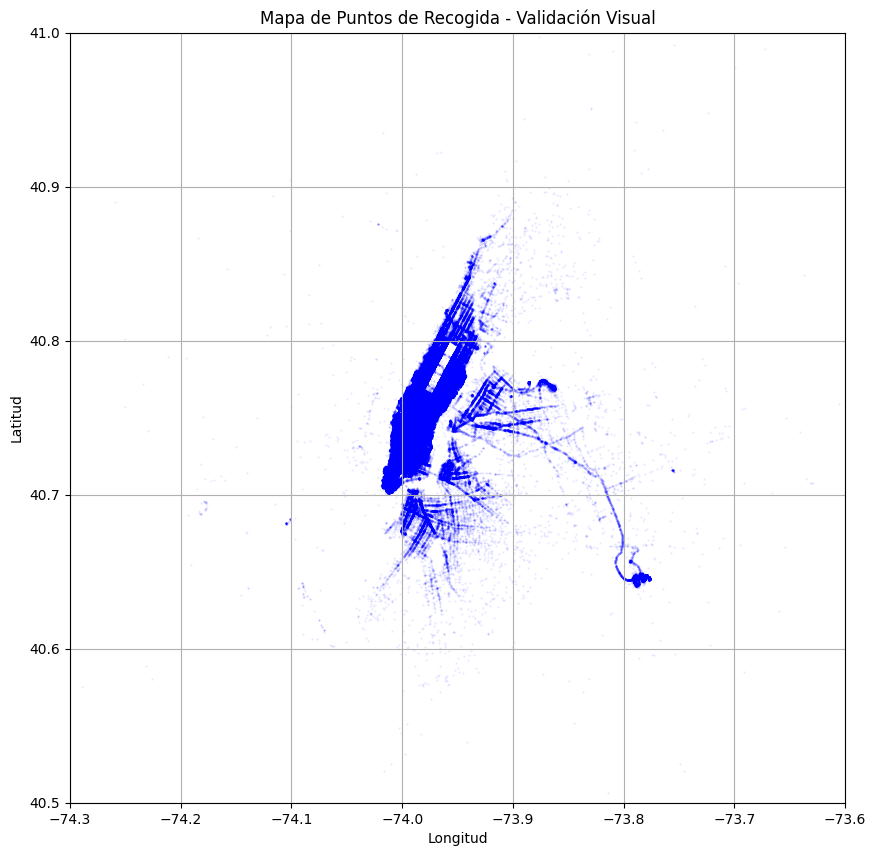

In [10]:
# --- LIMPIEZA DE COORDENADAS ---

# 1. Defino los límites geográficos de mi análisis (Bounding Box)
# Decido restringir el área a NYC y alrededores para eliminar errores de GPS (ej: coordenadas en el océano).
BB_lat_min, BB_lat_max = 40.5, 41.0
BB_lon_min, BB_lon_max = -74.3, -73.6

print(f"Límites que establecí: Lat [{BB_lat_min}, {BB_lat_max}], Long [{BB_lon_min}, {BB_lon_max}]")

# 2. Identifico cuántos datos caerían fuera de mi caja
# Esto me sirve para cuantificar la "basura" que estoy eliminando.
outliers_geo = df[
    (df.pickup_latitude < BB_lat_min) | (df.pickup_latitude > BB_lat_max) |
    (df.pickup_longitude < BB_lon_min) | (df.pickup_longitude > BB_lon_max) |
    (df.dropoff_latitude < BB_lat_min) | (df.dropoff_latitude > BB_lat_max) |
    (df.dropoff_longitude < BB_lon_min) | (df.dropoff_longitude > BB_lon_max)
]

print(f"Detecté {len(outliers_geo)} filas con coordenadas erróneas.")

# 3. Aplico el filtro definitivo
# Me quedo solo con los viajes que empiezan Y terminan dentro de mi área de interés.
df = df[
    (df.pickup_latitude >= BB_lat_min) & (df.pickup_latitude <= BB_lat_max) &
    (df.pickup_longitude >= BB_lon_min) & (df.pickup_longitude <= BB_lon_max) &
    (df.dropoff_latitude >= BB_lat_min) & (df.dropoff_latitude <= BB_lat_max) &
    (df.dropoff_longitude >= BB_lon_min) & (df.dropoff_longitude <= BB_lon_max)
]

print(f"Filas restantes después de mi limpieza geográfica: {df.shape[0]}")

# 4. Visualizo los datos para confirmar la coherencia espacial
# Genero un mapa de puntos (scatter plot) para verificar que la silueta se parezca a NYC.
plt.figure(figsize=(10, 10))
plt.scatter(df.pickup_longitude, df.pickup_latitude, s=0.2, alpha=0.1, c='blue')
plt.title("Mapa de Puntos de Recogida - Validación Visual")
plt.xlim(BB_lon_min, BB_lon_max)
plt.ylim(BB_lat_min, BB_lat_max)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.show()

## Enriquecimiento del dataset

### Agregado de datos meteorológicos
Vamos a agregar los datos meteorológicos para enriquecer el dataset